In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def create_table(path):
    df = pd.read_csv(path)
    return df

In [ ]:
# Generate dataframe from point share data
# Needs to be in the same folder as this notebook
path = "/content/drive/MyDrive/Jobs/Instacart/pointshares.csv"
point_shares = create_table(path)

# Make all the column names lowercase
point_shares.columns = point_shares.columns.str.lower()
# Make all the player names lowercase
point_shares['name'] = point_shares['name'].str.lower()
# Set the index of the dataframe to be the player name, we'll use this
# to merge the different dataframes
point_shares = point_shares.set_index('name')

# Check to make sure the DataFrame looks right
point_shares.head()

,league,height,weight,gp,ps
name,,,,,
taylor hall,OHL,72.75,186,658,65.7
tyler seguin,OHL,72.75,180,741,79.9
cam fowler,OHL,74.00,195,713,52.3
brett connolly,WHL,74.00,181,513,19.3
riley sheahan,CCHA,73.50,202,543,11.2


In [ ]:
# Generate dataframes from prospect data
# All files must be in the same folder as this notebook
path = "/content/drive/MyDrive/Jobs/Instacart/2010dy.csv"
prospects2010 = create_table(path)
path = "/content/drive/MyDrive/Jobs/Instacart/2011dy.csv"
prospects2011 = create_table(path)
path = "/content/drive/MyDrive/Jobs/Instacart/2012dy.csv"
prospects2012 = create_table(path)
path = "/content/drive/MyDrive/Jobs/Instacart/2013dy.csv"
prospects2013 = create_table(path)

In [ ]:
# Merge the DY dataframes into one dataframe
prospects = prospects2010.append([prospects2011, prospects2012, prospects2013])
# Make all the column names lowercase
prospects.columns = prospects.columns.str.lower()
# Drop irrelevant columns
prospects = prospects.drop(columns=['gp', 'player id', 'tg', 'tp1', 'tp', 'shoots'])

# Eliminate all records where the player is not in one of the CHL leagues
prospects = prospects[prospects['league'].isin(['OHL', 'WHL', 'QMJHL'])]
# Turn the name into lowercase for the purposes of joining with pointshares
prospects['name'] = prospects['name'].str.lower()
prospects = prospects.set_index('name')

prospects.head()

,league,dy+/-,season,ev p1/gp,pp p1/gp,tp/gp,goals/p1,ev gf%,ev gf%rel,etoi/gp,p1/e60,age sept 15
name,,,,,,,,,,,,
taylor hall,OHL,DY,2010,0.7895,0.5789,1.8596,46.15,69.03,9.64,17.23,5.0101,18.84
tyler seguin,OHL,DY,2010,0.8730,0.5238,1.6825,54.55,57.66,8.74,20.92,4.0053,18.63
jeff skinner,OHL,DY,2010,0.5781,0.6094,1.4063,64.47,54.84,6.73,19.20,3.8081,18.33
jordan weal,WHL,DY,2010,0.5694,0.5000,1.4167,45.45,53.49,13.78,15.50,4.1405,18.42
greg mckegg,OHL,DY,2010,0.5821,0.3433,1.2687,56.45,55.91,10.20,16.74,3.5845,18.24


In [ ]:
# Merge the dataframes
data = pd.merge(prospects, point_shares, on=['name', 'league'])
# Remove any duplicate values
data = data[~data.index.duplicated(keep='first')]
data.head()

,league,dy+/-,season,ev p1/gp,pp p1/gp,tp/gp,goals/p1,ev gf%,ev gf%rel,etoi/gp,p1/e60,age sept 15,height,weight,gp,ps
name,,,,,,,,,,,,,,,,
taylor hall,OHL,DY,2010,0.7895,0.5789,1.8596,46.15,69.03,9.64,17.23,5.0101,18.84,72.75,186,658,65.7
tyler seguin,OHL,DY,2010,0.8730,0.5238,1.6825,54.55,57.66,8.74,20.92,4.0053,18.63,72.75,180,741,79.9
jeff skinner,OHL,DY,2010,0.5781,0.6094,1.4063,64.47,54.84,6.73,19.20,3.8081,18.33,70.00,197,748,54.9
jordan weal,WHL,DY,2010,0.5694,0.5000,1.4167,45.45,53.49,13.78,15.50,4.1405,18.42,68.50,156,218,4.9
tyler toffoli,OHL,DY,2010,0.7077,0.2615,1.2154,58.73,60.98,6.81,18.36,3.1674,18.39,72.00,183,555,43.0


In [ ]:
# Because there are different levels of scoring in different leagues, a goal
# in one league may be less valuable than a goal in another league.
# There are translation factors that we can use to account for these differences.
# Here, we only standardize stats across the leagues related to scoring rates.
# Stats related to goal differential are already standardized based on league.
data['normal_factor'] = 0
# Define the translation factors
ohl_factor = 0.323
data.loc[data.league == "OHL", "normal_factor"] = ohl_factor
whl_factor = 0.302
data.loc[data.league == "WHL", "normal_factor"] = whl_factor
qmjhl_factor = 0.284
data.loc[data.league == "QMJHL", "normal_factor"] = qmjhl_factor
# Standardize the stats
data[["ev p1/gp", "pp p1/gp", "tp/gp", "p1/e60"]] = data[["ev p1/gp", "pp p1/gp", "tp/gp", "p1/e60"]].multiply(data["normal_factor"], axis="index")
# Remove columns we no longer need
data = data.drop(columns=['normal_factor'])
data.head()

,league,dy+/-,season,ev p1/gp,pp p1/gp,tp/gp,goals/p1,ev gf%,ev gf%rel,etoi/gp,p1/e60,age sept 15,height,weight,gp,ps
name,,,,,,,,,,,,,,,,
taylor hall,OHL,DY,2010,0.255009,0.186985,0.600651,46.15,69.03,9.64,17.23,1.618262,18.84,72.75,186,658,65.7
tyler seguin,OHL,DY,2010,0.281979,0.169187,0.543448,54.55,57.66,8.74,20.92,1.293712,18.63,72.75,180,741,79.9
jeff skinner,OHL,DY,2010,0.186726,0.196836,0.454235,64.47,54.84,6.73,19.20,1.230016,18.33,70.00,197,748,54.9
jordan weal,WHL,DY,2010,0.171959,0.151000,0.427843,45.45,53.49,13.78,15.50,1.250431,18.42,68.50,156,218,4.9
tyler toffoli,OHL,DY,2010,0.228587,0.084465,0.392574,58.73,60.98,6.81,18.36,1.023070,18.39,72.00,183,555,43.0


In [ ]:
# Create a metric that can be standardly applied to different draft years
# Because point shares are cumulative, players drafted in 2010 have a 
# "head start" on players drafted in 2013. Making the target variable
# point shares per game played in the NHL reduces this advantage.

# Create the column
data["ps/gp"] = data["ps"] / data["gp"]
# Account for div/0 errors
data.loc[data.gp == 0, "ps/gp"] = 0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize all features so that they are on similar scales
# Any one feature should not skew the model based on the
# magnitude of their absolute values

# Features are normalized based how well each player performed
# relative to the mean of a given feature

# Rename age column
data = data.rename(columns={"age sept 15": "age"})

# Choose the features to normalize
features_to_standardize = ["ev p1/gp", "pp p1/gp", "tp/gp", "goals/p1", "ev gf%", 
                         "ev gf%rel", "etoi/gp", "p1/e60", "height", "weight", "age"]
scaler = MinMaxScaler()
data[features_to_standardize] = scaler.fit_transform(data[features_to_standardize])

In [ ]:
quantiles = data.quantile([.95, .90, .85, .80, .75, .70])
quantiles

,season,ev p1/gp,pp p1/gp,tp/gp,goals/p1,ev gf%,ev gf%rel,etoi/gp,p1/e60,age,height,weight,gp,ps,ps/gp
0.95,2013.0,0.706757,0.532875,0.620519,0.734175,0.807804,0.705255,0.778117,0.627477,0.9400,0.782609,0.642105,523.00,30.175,0.070737
0.90,2013.0,0.606415,0.451066,0.529334,0.695400,0.761008,0.659231,0.696979,0.584921,0.8900,0.695652,0.594737,374.00,17.600,0.051358
0.85,2013.0,0.539920,0.388233,0.480781,0.666700,0.708731,0.638776,0.623393,0.518727,0.8250,0.652174,0.557895,279.00,8.275,0.034344
0.80,2013.0,0.490951,0.351657,0.443502,0.638900,0.677722,0.612943,0.589974,0.485200,0.7500,0.608696,0.526316,170.00,3.400,0.023729
0.75,2012.0,0.455699,0.325764,0.403208,0.609575,0.651771,0.597029,0.561857,0.453399,0.6825,0.565217,0.494737,72.75,0.925,0.014387
0.70,2012.0,0.423025,0.291762,0.374749,0.587750,0.627693,0.574943,0.526992,0.414694,0.6600,0.565217,0.473684,14.00,0.000,0.000000


In [ ]:
# A "star" player will be defined as someone who is in the 95th percentile or better in point shares per games played.
# To account for longevity, "star" players must also be in the 80th percentile of games played. The games played threshold 
# is weaker than it is for point shares per games played to account for differences in draft years. Younger players
# won't have had the opporunity to play as many games as older players. A "star" will be coded in the Type column of data as 2.

data.loc[(data["ps/gp"] >= quantiles.loc[0.95, 'ps/gp']) & (data["gp"] >= quantiles.loc[0.80, 'gp']), 'Type'] = 2

# A "good" player will be defined as someone who is between the 75th and 90th percentile in point shares per games played.
# As well, "good" players must also be in the 75th percentile of games played. A "good" player will be coded as 1.
# Players 1 FULL SEASON

data.loc[(data["ps/gp"] < quantiles.loc[0.95, 'ps/gp']) & (data["ps/gp"] >= quantiles.loc[0.75, 'ps/gp']) & 
         (data["gp"] >= quantiles.loc[0.75, 'gp']), 'Type'] = 1

# A "bust" will be defined as someone who is does not meet any of the previous criteria. For the purposes of this model,
# these players are considered unproductive draft picks. A "bust" will be coded as 0.

data.loc[data['Type'].isnull(), 'Type'] = 0

In [ ]:
data.Type.value_counts()

0.0    328
1.0     70
2.0     18
Name: Type, dtype: int64

In [ ]:
# Remove columns we no longer need
data = data.drop(columns=["gp", "ps", "ps/gp"])

In [ ]:
data

,league,dy+/-,season,ev p1/gp,pp p1/gp,tp/gp,goals/p1,ev gf%,ev gf%rel,etoi/gp,p1/e60,age,height,weight,Type
name,,,,,,,,,,,,,,,
taylor hall,OHL,DY,2010,0.904353,0.949951,0.986609,0.4615,0.850478,0.654382,0.494859,1.000000,0.84,0.456522,0.378947,2.0
tyler seguin,OHL,DY,2010,1.000000,0.859534,0.890046,0.5455,0.637437,0.638512,0.732005,0.799445,0.63,0.456522,0.315789,2.0
jeff skinner,OHL,DY,2010,0.662199,1.000000,0.739450,0.6447,0.584598,0.603068,0.621465,0.760085,0.33,0.217391,0.494737,2.0
jordan weal,WHL,DY,2010,0.609828,0.767135,0.694900,0.4545,0.559303,0.727385,0.383676,0.772700,0.42,0.086957,0.063158,1.0
tyler toffoli,OHL,DY,2010,0.810653,0.429111,0.635363,0.5873,0.699644,0.604479,0.567481,0.632203,0.39,0.391304,0.347368,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jacob sweeney,QMJHL,DY,2013,0.047941,0.000000,0.025937,0.6667,0.627693,0.448069,0.375964,0.032607,0.54,0.695652,0.610526,0.0
taylor green,WHL,DY,2013,0.032987,0.023628,0.027580,0.6667,0.092374,0.246517,0.237147,0.039097,0.68,0.869565,0.810526,0.0
kayle doetzel,WHL,DY,2013,0.043697,0.000000,0.035074,0.0000,0.419524,0.356551,0.460154,0.027377,0.24,0.586957,0.421053,0.0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data.columns

Index(['league', 'dy+/-', 'season', 'ev p1/gp', 'pp p1/gp', 'tp/gp',
       'goals/p1', 'ev gf%', 'ev gf%rel', 'etoi/gp', 'p1/e60', 'age', 'height',
       'weight', 'Type'],
      dtype='object')

In [ ]:
y_data = data.loc[:,['Type']]
X_data = data.drop(columns=['league','dy+/-', 'season','Type'])

In [ ]:
X_data

,ev p1/gp,pp p1/gp,tp/gp,goals/p1,ev gf%,ev gf%rel,etoi/gp,p1/e60,age,height,weight
name,,,,,,,,,,,
taylor hall,0.904353,0.949951,0.986609,0.4615,0.850478,0.654382,0.494859,1.000000,0.84,0.456522,0.378947
tyler seguin,1.000000,0.859534,0.890046,0.5455,0.637437,0.638512,0.732005,0.799445,0.63,0.456522,0.315789
jeff skinner,0.662199,1.000000,0.739450,0.6447,0.584598,0.603068,0.621465,0.760085,0.33,0.217391,0.494737
jordan weal,0.609828,0.767135,0.694900,0.4545,0.559303,0.727385,0.383676,0.772700,0.42,0.086957,0.063158
tyler toffoli,0.810653,0.429111,0.635363,0.5873,0.699644,0.604479,0.567481,0.632203,0.39,0.391304,0.347368
...,...,...,...,...,...,...,...,...,...,...,...
jacob sweeney,0.047941,0.000000,0.025937,0.6667,0.627693,0.448069,0.375964,0.032607,0.54,0.695652,0.610526
taylor green,0.032987,0.023628,0.027580,0.6667,0.092374,0.246517,0.237147,0.039097,0.68,0.869565,0.810526
kayle doetzel,0.043697,0.000000,0.035074,0.0000,0.419524,0.356551,0.460154,0.027377,0.24,0.586957,0.421053


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,random_state=12345)

***Model 1: Logistic Regression***

In [ ]:
# Model 1: Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_fit = LogisticRegression(max_iter=10000).fit(X_train, y_train.values.ravel())

# get model prediction
y_pred =lr_fit.predict(X_test)

#calculating accuracy
from sklearn.metrics import accuracy_score
display(accuracy_score(y_test, y_pred))

0.7976190476190477

In [ ]:
lr_fit.coef_

array([[-0.78690494, -1.28155894, -1.51884529,  0.34702878, -1.11442279,
         0.15578269, -1.22407498, -1.02355884,  0.87344765, -0.50097709,
         0.03981788],
       [ 0.36340109, -0.1646684 ,  0.55044269, -0.17930934,  0.50053408,
        -0.36947821,  0.44985393,  0.50810881, -0.41632906,  0.2065283 ,
        -0.16292154],
       [ 0.42350386,  1.44622734,  0.9684026 , -0.16771945,  0.61388871,
         0.21369553,  0.77422105,  0.51545003, -0.45711859,  0.29444879,
         0.12310365]])

In [ ]:
# Predicted probabilities of 0 or 1
model = LogisticRegression()
model.fit(X_train,y_train.values.ravel())
y_pred = model.predict_proba(X_test)
y_pred

array([[0.91881919, 0.07383936, 0.00734145],
       [0.7138311 , 0.23083863, 0.05533028],
       [0.9520464 , 0.04319972, 0.00475387],
       [0.89171975, 0.09866348, 0.00961678],
       [0.93332681, 0.05885977, 0.00781342],
       [0.92881491, 0.06513293, 0.00605216],
       [0.46135624, 0.42444496, 0.11419879],
       [0.94438659, 0.04959755, 0.00601586],
       [0.9008199 , 0.08935186, 0.00982824],
       [0.89524097, 0.09548648, 0.00927255],
       [0.93497103, 0.05877316, 0.00625581],
       [0.8876793 , 0.09956195, 0.01275875],
       [0.93401391, 0.05601048, 0.0099756 ],
       [0.46167627, 0.42408586, 0.11423787],
       [0.79796118, 0.17032463, 0.03171419],
       [0.88352816, 0.10413637, 0.01233547],
       [0.91921518, 0.07225867, 0.00852615],
       [0.67176767, 0.27832633, 0.049906  ],
       [0.69254119, 0.27144363, 0.03601518],
       [0.60227176, 0.33126688, 0.06646136],
       [0.85972336, 0.12173568, 0.01854096],
       [0.5323099 , 0.35066159, 0.11702851],
       [0.

In [ ]:
# Another way to find predicted probabilities of 0 or 1 (doing this to make sure above code is correct)

##predict probabilities of testing instances being in classes 0 or 1

model1 = LogisticRegression()
model1.fit(X_train,y_train.values.ravel())

predicted_prob=model1.predict_proba(X_test)

##turn it into a pandas dataframe

model1_pred=pd.DataFrame(predicted_prob,columns=["prob_0","prob_1","prob_2"])

 ##record the index of testing set target 

index = y_test.index.values

actual = y_test.reset_index(drop=True)

 ##putting actual target values and predicted probabilities from model into the same pandas dataframe, then reset index

predictions_log = pd.concat([actual,model1_pred], axis=1)

predictions_log.set_index(index,inplace=True)
display(predictions_log)

,Type,prob_0,prob_1,prob_2
philip tot,0.0,0.918819,0.073839,0.007341
john mcfarland,0.0,0.713831,0.230839,0.055330
jared hauf,0.0,0.952046,0.043200,0.004754
stephen macaulay,0.0,0.891720,0.098663,0.009617
luke cairns,0.0,0.933327,0.058860,0.007813
...,...,...,...,...
brett connolly,1.0,0.572418,0.350121,0.077461
jeff corbett,0.0,0.937814,0.054642,0.007544
jesse forsberg,0.0,0.898951,0.088609,0.012440
matt puempel,0.0,0.402256,0.389507,0.208237


In [ ]:
predictions_log.sort_values(by='prob_2',ascending=False).head(20)

,Type,prob_0,prob_1,prob_2
sean monahan,2.0,0.303232,0.421291,0.275476
matt puempel,0.0,0.402256,0.389507,0.208237
shane prince,1.0,0.255178,0.571223,0.173600
mark scheifele,2.0,0.473619,0.371932,0.154449
charles hudon,1.0,0.408735,0.460507,0.130758
hunter shinkaruk,0.0,0.532310,0.350662,0.117029
brendan gaunce,0.0,0.486714,0.397530,0.115756
valentin zykov,0.0,0.461676,0.424086,0.114238
stefan noesen,1.0,0.461356,0.424445,0.114199
christian thomas,0.0,0.539396,0.348078,0.112526


Actual picks
- Sean Monahan: 2013, 1st rd, 6th pk (6th overall)
- Matt Puempel: 2011, 1st rd, 24th pk (24th overall)
- Shane Prince: 2011, 2nd rd, 31st pk (61st overall)
- Mark Scheifele: 2011, 1st rd, 7th pk (7th overall)
- Charles Hudon: 2012, 5th rd, 1st pk (122nd overall)
- Hunter Shinkaruk: 2013, 1st rd, 24th pk (24th overall)
- Brendan Gaunce: 2012, 1st rd, 26th pk (26th overall)
- Valentin Zykov: 2013, 2nd rd, 7th pk (37th overall)
- Stefan Noesen: 2011, 1st rd, 21st pk (21st overall)
- Christian Thomas: 2010, 2nd rd, 10th pk, (40th overall)

In [ ]:
model1.coef_

array([[-0.78690494, -1.28155894, -1.51884529,  0.34702878, -1.11442279,
         0.15578269, -1.22407498, -1.02355884,  0.87344765, -0.50097709,
         0.03981788],
       [ 0.36340109, -0.1646684 ,  0.55044269, -0.17930934,  0.50053408,
        -0.36947821,  0.44985393,  0.50810881, -0.41632906,  0.2065283 ,
        -0.16292154],
       [ 0.42350386,  1.44622734,  0.9684026 , -0.16771945,  0.61388871,
         0.21369553,  0.77422105,  0.51545003, -0.45711859,  0.29444879,
         0.12310365]])

Logistic Regression Feature Coefficients For Player Type 0:
Feature 0: -0.78690
Feature 1: -1.28156
Feature 2: -1.51885
Feature 3: 0.34703
Feature 4: -1.11442
Feature 5: 0.15578
Feature 6: -1.22407
Feature 7: -1.02356
Feature 8: 0.87345
Feature 9: -0.50098
Feature 10: 0.03982


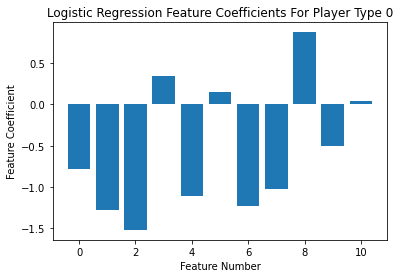

In [ ]:
from matplotlib import pyplot
# Get coefficients
importance = lr_fit.coef_[0]
# Summarize feature importance
# Print the feature ranking
print("Logistic Regression Feature Coefficients For Player Type 0:")
for i,v in enumerate(importance):
    print('Feature %0d: %.5f' % (i,v))
# Plot feature importance
# Reports the coefficient value for each feature.
pyplot.title("Logistic Regression Feature Coefficients For Player Type 0")
pyplot.xlabel("Feature Number")
pyplot.ylabel("Feature Coefficient")
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Logistic Regression Feature Coefficients For Player Type 1:
Feature 0: 0.36340
Feature 1: -0.16467
Feature 2: 0.55044
Feature 3: -0.17931
Feature 4: 0.50053
Feature 5: -0.36948
Feature 6: 0.44985
Feature 7: 0.50811
Feature 8: -0.41633
Feature 9: 0.20653
Feature 10: -0.16292


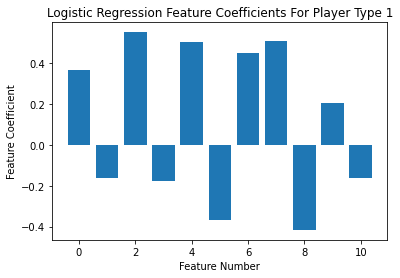

In [ ]:
from matplotlib import pyplot
# Get coefficients
importance = lr_fit.coef_[1]
# Summarize feature importance
# Print the feature ranking
print("Logistic Regression Feature Coefficients For Player Type 1:")
for i,v in enumerate(importance):
    print('Feature %0d: %.5f' % (i,v))
# Plot feature importance
# Reports the coefficient value for each feature.
pyplot.title("Logistic Regression Feature Coefficients For Player Type 1")
pyplot.xlabel("Feature Number")
pyplot.ylabel("Feature Coefficient")
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Logistic Regression Feature Coefficients For Player Type 2:
Feature 0: 0.42350
Feature 1: 1.44623
Feature 2: 0.96840
Feature 3: -0.16772
Feature 4: 0.61389
Feature 5: 0.21370
Feature 6: 0.77422
Feature 7: 0.51545
Feature 8: -0.45712
Feature 9: 0.29445
Feature 10: 0.12310


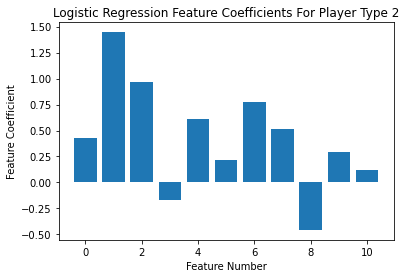

In [ ]:
from matplotlib import pyplot
# Get coefficients
importance = lr_fit.coef_[2]
# Summarize feature importance
# Print the feature ranking
print("Logistic Regression Feature Coefficients For Player Type 2:")
for i,v in enumerate(importance):
    print('Feature %0d: %.5f' % (i,v))
# Plot feature importance
# Reports the coefficient value for each feature.
pyplot.title("Logistic Regression Feature Coefficients For Player Type 2")
pyplot.xlabel("Feature Number")
pyplot.ylabel("Feature Coefficient")
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

***Model 2: KNN Classifier***

In [ ]:
# k-nearest neighbours
from sklearn.neighbors import KNeighborsClassifier
##fit training data, default model parameters
knn = KNeighborsClassifier().fit(X_train,y_train.values.ravel())
## get predicted values and class probabilities
knn_pred = pd.Series(knn.predict(X_test),name="knn_pred")
knn_prob = pd.DataFrame(knn.predict_proba(X_test),columns=["knn_prob_0","knn_prob_1",'knn_prob_2'])

In [ ]:
display(y_test) # displaying y_test to be able to compare the true values with the predicted values below

,Type
name,
philip tot,0.0
john mcfarland,0.0
jared hauf,0.0
stephen macaulay,0.0
luke cairns,0.0
...,...
brett connolly,1.0
jeff corbett,0.0
jesse forsberg,0.0


In [ ]:
display(knn_pred)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
79    0.0
80    0.0
81    0.0
82    0.0
83    0.0
Name: knn_pred, Length: 84, dtype: float64

In [ ]:
# Predicted probabilities for KNN model
display(knn_prob)

,knn_prob_0,knn_prob_1,knn_prob_2
0,1.0,0.0,0.0
1,0.8,0.2,0.0
2,0.8,0.2,0.0
3,0.6,0.4,0.0
4,1.0,0.0,0.0
...,...,...,...
79,1.0,0.0,0.0
80,1.0,0.0,0.0
81,0.8,0.2,0.0
82,0.8,0.0,0.2


In [ ]:
knn_prob['knn_prob_1'] # making sure I can get just the predicted probabilities of a 1

0     0.0
1     0.2
2     0.2
3     0.4
4     0.0
     ... 
79    0.0
80    0.0
81    0.2
82    0.0
83    0.0
Name: knn_prob_1, Length: 84, dtype: float64

In [ ]:
# mean accuracy on test data and labels for k-nearest neighbours
knn.score(X_test, y_test)

0.7619047619047619

***Model 3: Random Forest Classifier***

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(X_train,y_train.values.ravel())
rnd_pred = rnd_clf.predict(X_test)

print(rnd_clf.__class__.__name__, accuracy_score(y_test, rnd_pred))

RandomForestClassifier 0.7380952380952381


In [ ]:
# Features included in the models
print(np.array(X_data.columns))

['ev p1/gp' 'pp p1/gp' 'tp/gp' 'goals/p1' 'ev gf%' 'ev gf%rel' 'etoi/gp'
 'p1/e60' 'age' 'height' 'weight']


In [ ]:
# All features
print(np.array(data.columns))

['league' 'dy+/-' 'season' 'ev p1/gp' 'pp p1/gp' 'tp/gp' 'goals/p1'
 'ev gf%' 'ev gf%rel' 'etoi/gp' 'p1/e60' 'age' 'height' 'weight' 'Type']


In [ ]:
# Random forest classifier feature importance

importances = rnd_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rnd_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Random Forest Classifier Feature Ranking:")

for f in range(X_data.shape[1]):
    print("%d. Feature %d: (%f)" % (f + 1, indices[f], importances[indices[f]]))

Random Forest Classifier Feature Ranking:
1. Feature 2: (0.138845)
2. Feature 1: (0.126904)
3. Feature 7: (0.109428)
4. Feature 0: (0.108031)
5. Feature 4: (0.102324)
6. Feature 6: (0.080350)
7. Feature 5: (0.075982)
8. Feature 8: (0.075616)
9. Feature 3: (0.067654)
10. Feature 10: (0.058884)
11. Feature 9: (0.055981)


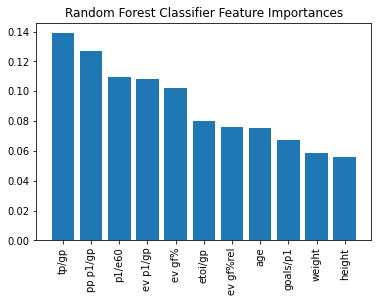

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances from our random forest model
importances = rnd_clf.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(np.array(X_data.columns))[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.title("Random Forest Classifier Feature Importances")
plt.show()

***Model 4: Gradient Boosting Classifier***

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators = 200, learning_rate = .5, max_depth = 1, random_state = 42).fit(X_train,y_train.values.ravel())
gb_clf.score(X_test,y_test)

0.7261904761904762

***Model 5: Tree Classification***

In [ ]:
from sklearn.tree import DecisionTreeClassifier
    
tree_fit = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

# get model prediction
y_pred =tree_fit.predict(X_test)

#calculating accuracy
display(accuracy_score(y_test, y_pred))

0.7261904761904762

***Model 6: Blended Model***

In [ ]:
X_train_pred = list(zip(lr_fit.predict(X_train), tree_fit.predict(X_train)))
X_train_pred = pd.DataFrame(X_train_pred)

clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
clf.fit(X_train_pred, y_train.values.ravel())

X_test_pred = list(zip(lr_fit.predict(X_test), tree_fit.predict(X_test)))
X_test_pred = pd.DataFrame(X_test_pred)


pred = clf.predict(X_test_pred)

print(clf.__class__.__name__, accuracy_score(y_test, pred))

RandomForestClassifier 0.7261904761904762
